## Environment Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
%cd rapidsai-csp-utils
!git checkout 22.12-patch
%cd ..
!python rapidsai-csp-utils/colab/env-check.py
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
/content/rapidsai-csp-utils
Already on '22.12-patch'
Your branch is up to date with 'origin/22.12-patch'.
/content
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla V100-SXM2-16GB!
***********************************************************************

***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla V100-SXM2-16GB!
We will now install RAPIDS via pip!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py): started
  error: subprocess-exited-with-error

  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.

  note: This error originates from a 

In [4]:
# Install the Merlin Framework
!pip install -U git+https://github.com/NVIDIA-Merlin/models.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/nvtabular.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/core.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/system.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/dataloader.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/Transformers4Rec.git@release-23.04
!pip install -U xgboost lightfm implicit

  Cloning https://github.com/NVIDIA-Merlin/models.git (to revision release-23.04) to /tmp/pip-req-build-l64k_rif
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA-Merlin/models.git /tmp/pip-req-build-l64k_rif
  Running command git checkout -b release-23.04 --track origin/release-23.04
  Switched to a new branch 'release-23.04'
  Branch 'release-23.04' set up to track remote branch 'release-23.04' from 'origin'.
  Resolved https://github.com/NVIDIA-Merlin/models.git to commit 56c7d6a4b2ec003472bdd176e972125632d070de
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 5.7 MB/s eta 0:00:00
  Installing buil

In [5]:
! pip install transformers

## Load Data
Reference
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/02-Merlin-Models-and-NVTabular-integration.ipynb

In [45]:
import os
import shutil
import numpy as np
from nvtabular import ops
from merlin.schema.tags import Tags
import merlin.io
import merlin.models.tf as mm

import nvtabular as nvt

from os import path

# Get dataframe library - cudf or pandas
from merlin.core.dispatch import get_lib
pd = get_lib()

In [5]:
DATA_DIR = os.environ.get(
    "DATA_DIR", os.path.expanduser("/content/drive/MyDrive/ml-twotower-model/data/")
)

### Prepare Custom Embeddings

In [6]:
# load dataset with synopsis
synopsis_df = pd.read_parquet(os.path.join(DATA_DIR, 'movielens_100k_synopsis_raw.parquet'))
synopsis_df.head()

,movie_id,title,synopsis,cast
0,242,Kolya (1996),Kolya (1996) is a Czech comedy-drama film dire...,"Zdeněk Svěrák, Andrej Chal"
1,257,Men in Black (1997),"In Men in Black, Will Smith plays a talented N...","Will Smith, Tommy Lee Jones, Linda Fiorentino,..."
2,111,"Truth About Cats & Dogs, The (1996)","""The Truth About Cats & Dogs"" is a romantic co...","Uma Thurman, Janeane Garofalo, Ben Chaplin"
3,25,"Birdcage, The (1996)","In ""Birdcage, The"", a gay cabaret owner and hi...","Robin Williams, Nathan Lane, Gene Hackman, Dia..."
4,382,"Adventures of Priscilla, Queen of the Desert, ...","""Adventures of Priscilla, Queen of the Desert""...","Terence Stamp, Hugo Weaving, Guy Pearce"


In [7]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel

from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [10]:
from tqdm import tqdm
def get_bert_embeddings(input, tokenizer, model, batch_size):
    # Tokenize the list of strings
    tokenized_inputs = tokenizer(input, padding=True, truncation=True, return_tensors="tf")

    # Get the number of samples in the dataset
    num_samples = len(tokenized_inputs["input_ids"])

    # Create a dataset from the tokenized inputs
    dataset = tf.data.Dataset.from_tensor_slices(tokenized_inputs)

    # Batch the dataset
    batched_dataset = dataset.batch(batch_size)

    # Initialize a list to store the embeddings
    embeddings = []

    # Pass the batched inputs through the BERT model to get the embeddings
    with tf.device('/GPU:0'):  # Use GPU if available for faster inference
        for batch in tqdm(batched_dataset):
            batch_embeddings = model(**batch)[0]
            embeddings.append(batch_embeddings)

    # Concatenate the embeddings from different batches
    embeddings = tf.concat(embeddings, axis=0)

    return embeddings

In [214]:
from tqdm import tqdm
def get_bert_embeddings_pooled(input, tokenizer, model, batch_size):
    # Tokenize the list of strings
    tokenized_inputs = tokenizer(input, padding=True, truncation=True, return_tensors="tf")

    # Get the number of samples in the dataset
    num_samples = len(tokenized_inputs["input_ids"])

    # Create a dataset from the tokenized inputs
    dataset = tf.data.Dataset.from_tensor_slices(tokenized_inputs)

    # Batch the dataset
    batched_dataset = dataset.batch(batch_size)

    # Initialize a list to store the embeddings
    embeddings = []

    # Pass the batched inputs through the BERT model to get the embeddings
    with tf.device('/GPU:0'):  # Use GPU if available for faster inference
        for batch in tqdm(batched_dataset):
            batch_embeddings = model(**batch)[0]
            pooled = tf.reduce_mean(batch_embeddings, axis=1)
            embeddings.append(pooled)

    # Concatenate the embeddings from different batches
    embeddings = tf.concat(embeddings, axis=0)

    return embeddings

In [217]:
batch_size = 64
synopsis_embeddings = get_bert_embeddings_pooled(synopsis_df['synopsis'].tolist(), tokenizer, bert_model, batch_size)

100%|██████████| 27/27 [00:04<00:00,  6.11it/s]


In [218]:
batch_size = 64
title_embeddings = get_bert_embeddings_pooled(synopsis_df['title'].tolist(), tokenizer, bert_model, batch_size)

100%|██████████| 27/27 [00:05<00:00,  5.26it/s]


In [219]:
# index are require to replce string with embedding
synopsis_index, title_index = {}, {}
synopsis_ls = synopsis_df['synopsis'].tolist()
title_ls = synopsis_df['title'].tolist()
for i in range(len(synopsis_ls)):
    synopsis_index[synopsis_ls[i]] = i
    title_index[title_ls[i]] = i

In [220]:
synopsis_df['cast'] = synopsis_df['cast'].apply(str.lower).str.split(',')

TypeError: ignored

In [222]:
from functools import cache
def title_index_lambdaop(col):
    @cache
    def _get_title_embedding(input):
        # print(title_embeddings[title_index[input]].shape)
        return title_embeddings[title_index[input]]
    _col = col.apply(_get_title_embedding)
    return _col

def synopsis_index_lambdaop(col):
    @cache
    def _get_synopsis_embedding(input):
        return synopsis_embeddings[synopsis_index[input]]
    _col = col.apply(_get_synopsis_embedding)
    return _col

In [ ]:

# Define the custom embedding function using LambdaOp
def custom_embedding(col_name):
    def custom_func(df):
        return df[col_name].map(custom_embeddings[col_name])

    return custom_func

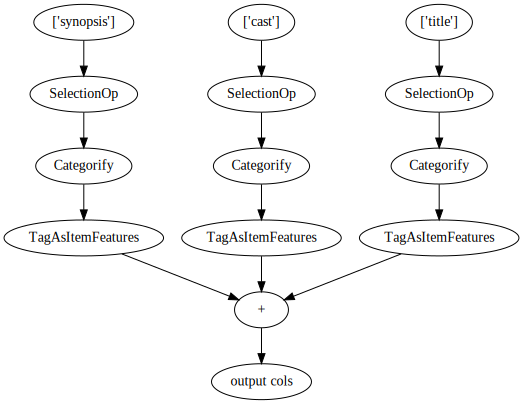

In [223]:
aug_feats_item_title = ['title'] >> ops.Categorify() >> ops.TagAsItemFeatures()
aug_feats_item_synopsis = ['synopsis'] >> ops.Categorify() >> ops.TagAsItemFeatures()

aug_feats_item_cast = ['cast'] >> ops.Categorify() >> ops.TagAsItemFeatures()
output = aug_feats_item_title + aug_feats_item_synopsis + aug_feats_item_cast
output.graph

In [224]:
synopsis_mdf = merlin.io.dataset.Dataset(synopsis_df)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [225]:
synopsis_mdf.to_ddf().compute()

,movie_id,title,synopsis,cast
0,242,Kolya (1996),Kolya (1996) is a Czech comedy-drama film dire...,"[zdeněk svěrák, andrej chal]"
1,257,Men in Black (1997),"In Men in Black, Will Smith plays a talented N...","[will smith, tommy lee jones, linda fiorenti..."
2,111,"Truth About Cats & Dogs, The (1996)","""The Truth About Cats & Dogs"" is a romantic co...","[uma thurman, janeane garofalo, ben chaplin]"
3,25,"Birdcage, The (1996)","In ""Birdcage, The"", a gay cabaret owner and hi...","[robin williams, nathan lane, gene hackman, ..."
4,382,"Adventures of Priscilla, Queen of the Desert, ...","""Adventures of Priscilla, Queen of the Desert""...","[terence stamp, hugo weaving, guy pearce]"
...,...,...,...,...
1677,1310,"Walk in the Sun, A (1945)","""A Walk in the Sun"" is a 1945 war drama film t...","[dana andrews, richard conte, george tyne, ..."
1678,1614,"Reluctant Debutante, The (1958)",The Reluctant Debutante (1958) tells the story...,"[rex harrison, kay kendall, john saxon, san..."
1679,1505,Killer: A Journal of Murder (1995),"""Killer: A Journal of Murder"" is a 1995 crime ...","[james woods, robert sean leonard, ellen gre..."
1680,1533,I Don't Want to Talk About It (De eso no se ha...,"""I Don't Want to Talk About It"" (De eso no se ...","[marcello mastroianni, luisina brando, aleja..."


In [226]:
# # make the divion on the basis of train, val, test
_aug_train = merlin.io.dataset.Dataset.merge(train, synopsis_mdf, on='movie_id')
_aug_val = merlin.io.dataset.Dataset.merge(valid, synopsis_mdf, on='movie_id')

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [227]:
%%time
workflow = nvt.Workflow(output)
_aug_train = workflow.fit_transform(_aug_train)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


CPU times: user 967 ms, sys: 41.6 ms, total: 1.01 s
Wall time: 1.01 s


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [228]:
_aug_train.to_ddf().compute()

,title,synopsis,cast
0,5,5,"[23, 18, 32, 168, 171]"
1,5,5,"[23, 18, 32, 168, 171]"
2,5,5,"[23, 18, 32, 168, 171]"
3,5,5,"[23, 18, 32, 168, 171]"
4,5,5,"[23, 18, 32, 168, 171]"
...,...,...,...
79995,1595,1550,"[4410, 2483, 4520, 4491]"
79996,1496,1517,"[1880, 316, 1378]"
79997,1580,1563,"[4631, 168, 1392, 1652, 4391]"
79998,1603,1494,"[4559, 4377, 4416, 4302, 4422]"


In [229]:
_aug_train.schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.start_index,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.value_count.min,properties.value_count.max
0,title,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,0,0,0,.//categories/unique.title.parquet,0,1604,title,1605,100,NaN,NaN
1,synopsis,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,0,0,0,.//categories/unique.synopsis.parquet,0,1604,synopsis,1605,100,NaN,NaN
2,cast,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,None,0,0,0,.//categories/unique.cast.parquet,0,4633,cast,4634,181,0.0,NaN


In [230]:
schema = _aug_train.schema

In [233]:
schema['title'].properties['embedding_sizes'] = {
    'cardinality': float(title_embeddings.shape[0]),
    'dimension': float(title_embeddings.shape[1])
}

schema['synopsis'].properties['embedding_sizes'] = {
    'cardinality': float(synopsis_embeddings.shape[0]),
    'dimension': float(synopsis_embeddings.shape[1])
}

In [234]:
_aug_train.schema = schema
_aug_train.schema



,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.start_index,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.value_count.min,properties.value_count.max
0,title,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,0,0,0,.//categories/unique.title.parquet,0,1604,title,1682.0,768.0,NaN,NaN
1,synopsis,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,0,0,0,.//categories/unique.synopsis.parquet,0,1604,synopsis,1682.0,768.0,NaN,NaN
2,cast,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,None,0,0,0,.//categories/unique.cast.parquet,0,4633,cast,4634.0,181.0,0.0,NaN


### Prepare final dataset

In [24]:
import glob

TRAIN_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, "train", "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, "valid", "*.parquet")))
TEST_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, "test", "*.parquet")))
TRAIN_PATHS, VALID_PATHS, TEST_PATHS

(['/content/drive/MyDrive/ml-twotower-model/data/train/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/valid/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/test/part_0.parquet'])

In [25]:
train = merlin.io.Dataset(
    os.path.join(DATA_DIR, "train"), engine="parquet"
)
valid = merlin.io.Dataset(
    os.path.join(DATA_DIR, "valid"), engine="parquet"
)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.1

In [26]:
schema = train.schema.select_by_tag([Tags.ITEM_ID, Tags.USER_ID, Tags.ITEM, Tags.USER])
schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.start_index,properties.embedding_sizes.dimension,properties.embedding_sizes.cardinality,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.value_count.min,properties.value_count.max
0,movie_id,"(Tags.ITEM, Tags.ITEM_ID, Tags.ID, Tags.CATEGO...","DType(name='int64', element_type=<ElementType....",False,False,None,0.0,0.0,0.0,100.0,1617.0,.//categories/unique.movie_id.parquet,0,1616,movie_id,NaN,NaN
1,user_id,"(Tags.USER, Tags.ID, Tags.CATEGORICAL, Tags.US...","DType(name='int64', element_type=<ElementType....",False,False,None,0.0,0.0,0.0,65.0,752.0,.//categories/unique.user_id.parquet,0,751,user_id,NaN,NaN
2,gender,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,0.0,0.0,0.0,16.0,3.0,.//categories/unique.gender.parquet,0,2,gender,NaN,NaN
3,occupation,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,0.0,0.0,0.0,16.0,22.0,.//categories/unique.occupation.parquet,0,21,occupation,NaN,NaN
4,genres,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,None,0.0,0.0,0.0,16.0,20.0,.//categories/unique.genres.parquet,0,19,genres,0.0,NaN


In [28]:
train.schema['movie_id'].properties['embedding_sizes']['cardinality']

1617.0

In [ ]:
# select only trainable features and exclude the target
train.schema = schema
valid.schema = schema

In [ ]:
assert len(schema.select_by_tag(Tags.TARGET).column_names) == 0

## Build Model
Reference
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb

In [243]:
train.schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.start_index,properties.embedding_sizes.dimension,properties.embedding_sizes.cardinality,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.value_count.min,properties.value_count.max
0,movie_id,"(Tags.ITEM, Tags.ITEM_ID, Tags.ID, Tags.CATEGO...","DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,0.0,100.0,1617.0,.//categories/unique.movie_id.parquet,0.0,1616.0,movie_id,NaN,NaN
1,user_id,"(Tags.USER, Tags.ID, Tags.CATEGORICAL, Tags.US...","DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,0.0,65.0,752.0,.//categories/unique.user_id.parquet,0.0,751.0,user_id,NaN,NaN
2,gender,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,0.0,16.0,3.0,.//categories/unique.gender.parquet,0.0,2.0,gender,NaN,NaN
3,occupation,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,0.0,16.0,22.0,.//categories/unique.occupation.parquet,0.0,21.0,occupation,NaN,NaN
4,genres,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,NaN,0.0,0.0,0.0,16.0,20.0,.//categories/unique.genres.parquet,0.0,19.0,genres,0.0,NaN
5,rating,"(Tags.BINARY_CLASSIFICATION, Tags.TARGET)","DType(name='float32', element_type=<ElementTyp...",False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [244]:
schema = train.schema

In [245]:
schema['title'].properties['embedding_sizes'] = {
    'cardinality': float(title_embeddings.shape[0]),
    'dimension': float(title_embeddings.shape[1])
}

schema['synopsis'].properties['embedding_sizes'] = {
    'cardinality': float(synopsis_embeddings.shape[0]),
    'dimension': float(synopsis_embeddings.shape[1])
}

KeyError: ignored

In [ ]:
_aug_train.schema = schema
_aug_train.schema


In [ ]:
tower_dim = 64

# create user schema using USER tag
user_schema = schema.select_by_tag(Tags.USER)
# create user (query) tower input block
user_inputs = mm.InputBlockV2(user_schema)
# create user (query) encoder block
query = mm.Encoder(user_inputs, mm.MLPBlock([128, tower_dim], no_activation_last_layer=True))

# create item schema using ITEM tag
item_schema = schema.select_by_tag(Tags.ITEM)
# create item (candidate) tower input block
item_inputs = mm.InputBlockV2(item_schema)
# create item (candidate) encoder block
candidate = mm.Encoder(item_inputs, mm.MLPBlock([128, tower_dim], no_activation_last_layer=True))

In [ ]:
model = mm.TwoTowerModelV2(query, candidate)


In [ ]:
model.compile(optimizer="adam", run_eagerly=False, metrics=[mm.RecallAt(10), mm.NDCGAt(10)])
model.fit(train, validation_data=valid, batch_size=128, epochs=10)

/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed i

Epoch 1/10
625/625 [==============================] - 19s 23ms/step - loss: 1.8251 - recall_at_10: 0.9156 - ndcg_at_10: 0.5878 - regularization_loss: 0.0000e+00 - loss_batch: 1.8253 - val_loss: 10.4536 - val_recall_at_10: 0.1829 - val_ndcg_at_10: 0.0967 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 5.2564
Epoch 2/10
625/625 [==============================] - 15s 23ms/step - loss: 1.7920 - recall_at_10: 0.9243 - ndcg_at_10: 0.6035 - regularization_loss: 0.0000e+00 - loss_batch: 1.7921 - val_loss: 13.2606 - val_recall_at_10: 0.1859 - val_ndcg_at_10: 0.0989 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 7.6321
Epoch 3/10
625/625 [==============================] - 15s 23ms/step - loss: 1.7825 - recall_at_10: 0.9238 - ndcg_at_10: 0.6072 - regularization_loss: 0.0000e+00 - loss_batch: 1.7826 - val_loss: 12.8874 - val_recall_at_10: 0.1881 - val_ndcg_at_10: 0.1014 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 8.2507
Epoch 4/10
625/625 [=============================

### Evaluate the Model top-k results

In [ ]:
# Top-K evaluation
from merlin.models.utils.dataset import unique_rows_by_features

candidate_features = unique_rows_by_features(train, Tags.ITEM, Tags.ITEM_ID)
candidate_features.head()

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


,movie_id,gender,occupation,genres
0,1,1,1,"[6, 3, 8, 5, 7]"
1,45,1,3,"[2, 5]"
2,357,1,1,"[1, 5]"
3,270,1,2,[1]
4,336,1,15,[4]


In [ ]:
topk = 20
topk_model = model.to_top_k_encoder(candidate_features, k=topk, batch_size=128)

# we can set `metrics` param in the `compile(), if we want
topk_model.compile(run_eagerly=False)

/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


ValueError: ignored

## TMP

In [236]:
train_df = train.to_ddf().compute()

In [238]:
train_df['movie_id'].value_counts()

1       473
2       423
3       417
4       396
5       394
       ... 
1511      1
1534      1
1499      1
1493      1
1483      1
Name: movie_id, Length: 1616, dtype: int64

In [241]:
_aug_train_df = _aug_train.to_ddf().compute()

In [242]:
_aug_train_df['movie_id'].value_counts()

KeyError: ignored